In [5]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import statistics
import kmax as kx
import utility as util
from hierarchy import *
from scipy.optimize import fsolve
from IPython.core.debugger import set_trace
import scipy.stats as stats
import pylab
import math

In [43]:
num_samples = 10**6

### Function Definitions

In [44]:
# Calculate the length of the path passing 
# through `node` in `path_cover`
def path_seg_length(tree, path_cover, node):
    if len(path_cover) == 0:
        return 0
    
    path_subgraph = tree.edge_subgraph(path_cover)
    if node not in path_subgraph:
        return 0

    # node_connected_component returns a list of nodes, so we subtract 1 to get the number of edges
    return len(nx.node_connected_component(path_subgraph, node)) - 1

def all_path_seg_lengths(tree):
    hist_data = {}
    component_root = 0
    path_cover,_,_,_ = util.path_cover(tree, root=component_root)
    path_subgraph = tree.edge_subgraph(path_cover)
    for path in nx.connected_components(path_subgraph):
        seg_len = len(path) - 1
        if seg_len not in hist_data:
            hist_data[seg_len] = 1
        else:
            hist_data[seg_len] += 1
    return hist_data

def root_seg_length(tree):
    path_cover,_,_,_ = util.path_cover(tree, root=0)
    return path_seg_length(tree, path_cover, 0)

def root_seg_length_z(tree):
    path_cover,_,_,z_root = util.path_cover(tree, root=0)
    return path_seg_length(tree, path_cover, 0), z_root

In [45]:
def run_samples(graph_gen, sup_crit=False):
    root_seg_lengths_z0 = []
    root_seg_lengths_z1 = []
    while len(root_seg_lengths_z0) + len(root_seg_lengths_z1) < num_samples:
        sample_tree = graph_gen()
        for u,v in sample_tree.edges():
            sample_tree[u][v]['weight'] = 1

        if sup_crit and nx.diameter(sample_tree) < 10:
            continue
    
        seg_len, z_root = root_seg_length_z(sample_tree)
        if z_root == 0:
            root_seg_lengths_z0.append(seg_len)
        else:
            root_seg_lengths_z1.append(seg_len)
    return root_seg_lengths_z0, root_seg_lengths_z1

#### Theoretical value approximations

In [46]:
def solve_p(lam):
    func = lambda p: [p[0] * np.exp(lam*p[0]) - (1 + lam * p[0])]
    return float(fsolve(func, 1)[0])

def solve_r(lam):
    p = solve_p(lam)
    return lam * np.exp(-lam * p)

def compute_L(k, lam):
    p = solve_p(lam)
    r = solve_r(lam)
    return (1-r) * r**(k-2) * (p * r**2 + (1-p) * (1-r) * max(0,(k-1)))

def compute_L_one(k, lam):
    p = solve_p(lam)
    r = lam * np.exp(-lam * p)
    return  (1-r) * math.pow(r, k)
               
def compute_L_zero(k, lam):
    p = solve_p(lam)
    r = lam * np.exp(-lam * p)
    return  math.pow(1-r, 2) * math.pow(r, k - 2) * max(0, (k-1))

def compute_mu_from_lambda(lam):
    e_val = lam * math.exp(-1 * lam)
    func = lambda mu : [mu[0] * math.exp(-1 * mu[0]) - e_val]
    if lam > 1:
        return float(fsolve(func, 0)[0])
    else:
        return float(fsolve(func, 2)[0])

In [60]:
def draw_tree(tree, layout, draw_path=True):
    rooted_tree = nx.bfs_tree(tree, 0)
    
    #nx.draw_networkx_nodes(tree, pos=layout, node_size=29)
    nx.draw_networkx_labels(tree, pos=layout, font_size=10, font_color="tab:blue")
    
    if draw_path:
        path_cover,_,X,_=util.path_cover(tree)
        nx.draw_networkx_edges(rooted_tree, pos=layout, edgelist=path_cover, edge_color="tab:red", arrows=True)
        
        other_edges = [(u,v) for u,v in rooted_tree.edges() if (u,v) not in path_cover and (v,u) not in path_cover]
        nx.draw_networkx_edges(rooted_tree, pos=layout, edgelist=other_edges)
    else:
        nx.draw_networkx_edges(rooted_tree, pos=layout)

def generate_histogram(dataset, func, bins = np.arange(0,100,1), title=None):
    theoretical_seg_lengths = [func(k) for k in bins]
    plt.figure(figsize=(6,6))
    plt.bar(bins, theoretical_seg_lengths, color='red', width=1, label='Theoretical')
    plt.hist(dataset, bins=bins, density=True, edgecolor = 'black', linewidth=1.2, color = 'lightblue', alpha=0.5, label='Experimental')
    if title:
        plt.title(title, fontfamily=['Serif'])
    else:
        #plt.title(f"Path segment length\n(GWBP, $\\lambda={LAM}$, {num_samples} samples)", fontfamily=['Serif'])
        asdf = None
    plt.xticks(bins)
    plt.xlabel("Root path length", fontfamily=['Serif'], fontsize=12)
    plt.ylabel("Probability", fontfamily=['Serif'], fontsize=12)
    plt.legend(loc='upper right')
    plt.show()

### Single Sample

In [7]:
#sample_tree = nx.fast_gnp_random_graph(n, lam/n)
sample_tree = nx.random_labeled_tree(30)
for u,v in sample_tree.edges():
    sample_tree[u][v]['weight'] = 1

seg_length_counts = all_path_seg_lengths(sample_tree)

In [8]:
seg_length_counts

{14: 1, 2: 2, 3: 1}

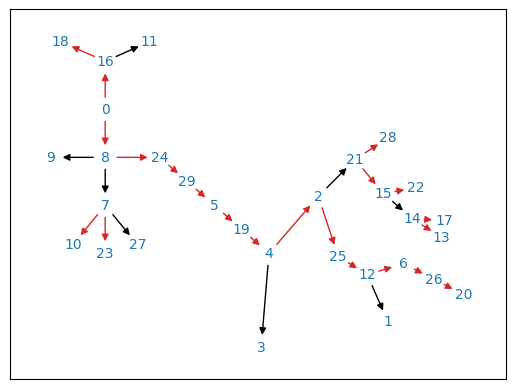

In [9]:
draw_tree(sample_tree, hierarchyc_pos(sample_tree, root=0))

# Galton-Watson Branching Process - $\text{Pois}(\lambda)$

## Subcritical case $(\lambda < 1)$

In [49]:
LAM = 0.7

### Average Segment Length

In [11]:
seg_lengths = []
for _ in range(num_samples):
    # Poisson Branching
    sample_tree = nx.Graph(GWBP(LAM, MAXLEVEL=100))
    for u,v in sample_tree.edges():
        sample_tree[u][v]['weight'] = 1

    for (l,c) in all_path_seg_lengths(sample_tree).items():
        for _ in range(c):
            seg_lengths.append(l)

### Root segment length

In [50]:
root_seg_lengths = []
for _ in range(num_samples):
    sample_tree = nx.Graph(GWBP(LAM, MAXLEVEL=100))
    for u,v in sample_tree.edges():
        sample_tree[u][v]['weight'] = 1

    root_seg_lengths.append(root_seg_length(sample_tree))

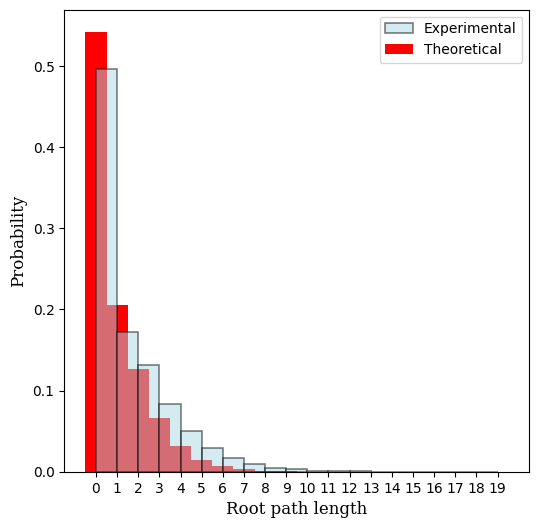

In [61]:
theoretical_func = lambda k: compute_L(k, LAM)
generate_histogram(root_seg_lengths, func=theoretical_func, bins=np.arange(0,20,1))

### Root segmenth length (split by z)

Let $L$ be a random variable denoting the length of the path segment passing through the root of a GWBP tree $(\text{Pois}(\lambda))$.

Further, let $L_0$ denote the length of the root path segment $L$ conditioning on $z_{\text{root}}=0$.

Similarly, let $L_1$ denote the length of the root path segment $L$ conditioning on $z_{\text{root}}=1$.

Then we expect
$$
\begin{align*}
L_0 &\sim \text{geom}(1-r) \oplus \text{geom}(1-r), \\
L_1 &\sim \text{geom}(1-r) - 1,
\end{align*}
$$
where $r = \lambda e^{-\lambda p}$ and $p$ is the solution to the equation
$$
p = (1+\lambda p) e^{-\lambda p} = \mathbb{P}(z_{\text{root}}=1).
$$

In [52]:
func = lambda: nx.Graph(GWBP(0.7, MAXLEVEL=100))
rsl_z0, rsl_z1 = run_samples(func)
len(rsl_z1) / num_samples

0.874675

We should have $\mathbb{P}(z_{\text{root}}=1)=p$.
Let's compute a sample probability and compare:

In [53]:
print(f'p = {solve_p(0.7)}')
print(f'# z(root)=0 = {len(rsl_z0)}')
print(f'# z(root)=1 = {len(rsl_z1)}')
print(f'sample P(z(root)=1) = {len(rsl_z1) / num_samples}')

p = 0.8741606425132523
# z(root)=0 = 125325
# z(root)=1 = 874675
sample P(z(root)=1) = 0.874675


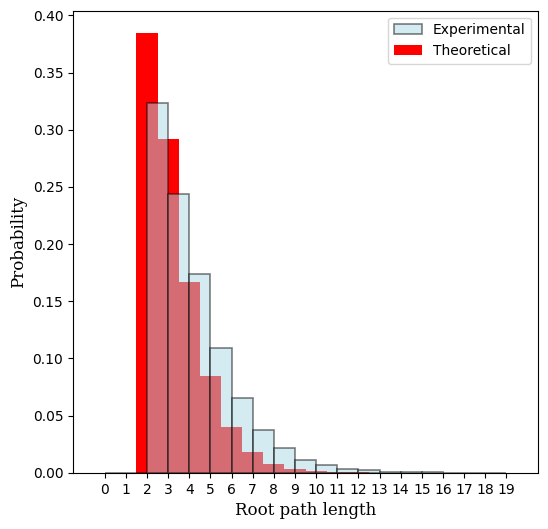

In [62]:
zero_dist = lambda k: compute_L_zero(k, LAM)
generate_histogram(rsl_z0, func=zero_dist, bins=np.arange(0,20,1))
#                   title = f"Path segment length, $z=0$\n(GWBP, $\\lambda={LAM}$, {num_samples} samples)")

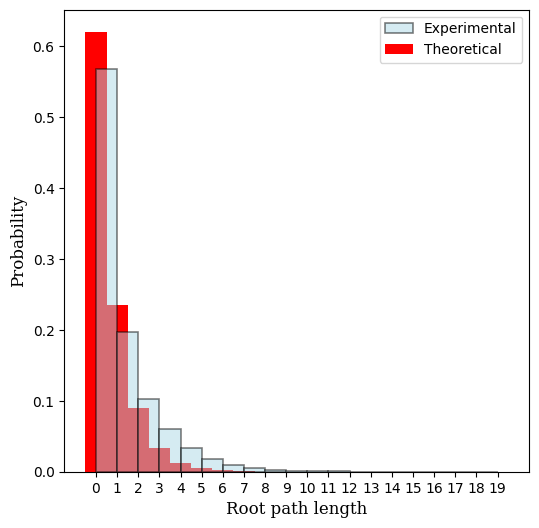

In [63]:
one_dist = lambda k: compute_L_one(k, LAM)
generate_histogram(rsl_z1, func=one_dist, bins=np.arange(0,20,1))
#                   title = f"Path segment length, $z=1$\n(GWBP, $\\lambda={LAM}$, {num_samples} samples)")

## Supercritical case $(\lambda > 1)$
Note: we discard any trees that "go extinct" before MAXLEVEL (i.e., have level < MAXLEVEL = 10).

In [15]:
def supcrit_X_N(lam, my_max):
    finite_vals = []
    infinite_vals = []
    for _ in range(num_samples):
        # Poisson Branching
        sample_tree, is_finite = GWBP_finite_flag(lam, MAXLEVEL=my_max)
        sample_tree = nx.Graph(sample_tree)
        for u,v in sample_tree.edges():
            sample_tree[u][v]['weight'] = 1
    
        _,_,X,_ = util.path_cover(sample_tree,root=0)
        val = X / sample_tree.number_of_nodes() # X / n
        if is_finite:
            finite_vals.append(val)
        else:
            infinite_vals.append(val)
    return finite_vals, infinite_vals

In [16]:
def supcrit_infinite_hist(inf_vals):
    mean = np.mean(inf_vals)
    std = np.var(inf_vals) ** 0.5
    yy = [(x - mean) / std for x in inf_vals]
    xx = np.linspace(-3,3,100)
    kde = stats.gaussian_kde(inf_vals)
    plt.hist(yy, bins=xx, density=True)
    #plt.plot(xx, kde(xx))
    plt.plot(xx, stats.norm.pdf(xx, 0, 1))
    plt.title('Histogram of $\\frac{X}{N}$ when tree is infinite\n' + f'(GWBP, $\\lambda={LAM}$, MAXLEVEL={my_maxlevel}, {num_samples} samples)')
    plt.xlabel('$X/N$')
    plt.ylabel('Density')
    plt.show()
    return mean, std

In [17]:
LAM = 1.5
my_maxlevel = 15
finite_vals, infinite_vals = supcrit_X_N(LAM, my_maxlevel)

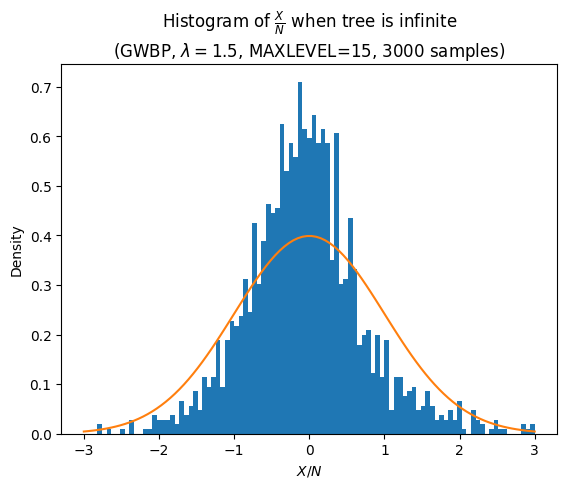

(np.float64(0.6728248265681049), np.float64(0.014640210915085754))

In [18]:
supcrit_infinite_hist(infinite_vals)

In [22]:
solve_p(LAM)

0.7112014274154725

In [23]:
# Without discarding (matches theoretical value of p better)
func = lambda: nx.Graph(GWBP(LAM, MAXLEVEL=10))
rsl_z0_no_disc, rsl_z1_no_disc = run_samples(func, sup_crit=False)
len(rsl_z1_no_disc) / num_samples

0.7146666666666667

In [24]:
# With discarding
rsl_z0, rsl_z1 = run_samples(func, sup_crit=True)
rsls = rsl_z0 + rsl_z1
len(rsl_z1) / num_samples

0.555

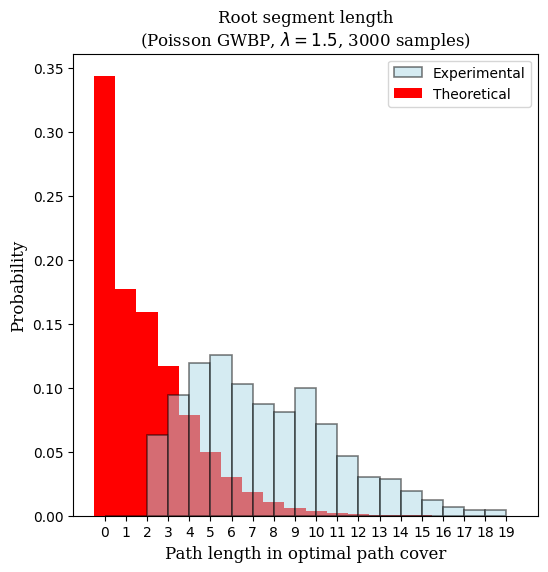

In [25]:
generate_histogram(rsls, lambda k: compute_L(k, LAM), bins=np.arange(0,20,1),
                  title=f'Root segment length\n(Poisson GWBP, $\\lambda={LAM}$, {num_samples} samples)')

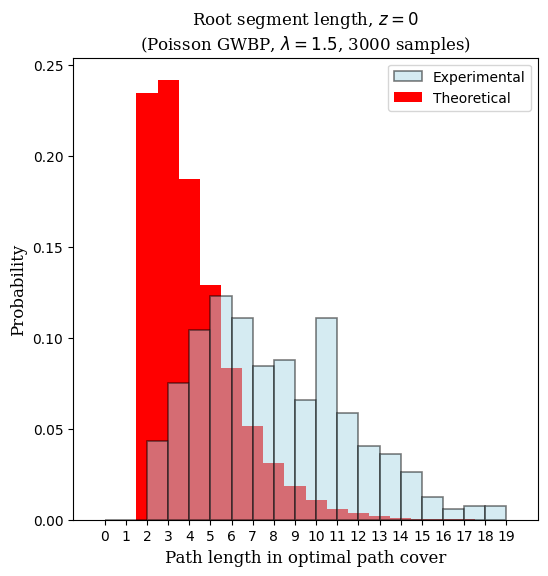

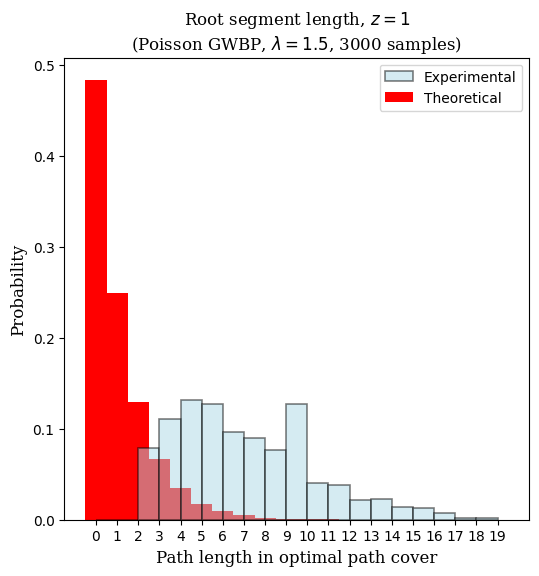

In [26]:
generate_histogram(rsl_z0, lambda k: compute_L_zero(k, LAM), bins=np.arange(0,20,1),
                   title = f"Root segment length, $z = 0$\n(Poisson GWBP, $\\lambda={LAM}$, {num_samples} samples)")
generate_histogram(rsl_z1, lambda k: compute_L_one(k, LAM), bins=np.arange(0,20,1),
                   title= f"Root segment length, $z = 1$\n(Poisson GWBP, $\\lambda={LAM}$, {num_samples} samples)")

# Galton-Watson Branching Process - $\mathcal{U}(0,0,1,2)$ (subcritical)

### Theoretical distribution

In [27]:
def compute_m_unif(t):
    prob_xi_k = 0.25 # xi = U{0,1,2,3}
    return sum(t**k * prob_xi_k for k in [0,1,2,0])

def compute_m_prime_unif(t):
    prob_xi_k = 0.25 # xi = U{0,1,2,3}
    return sum(k * t**(k-1) * prob_xi_k for k in [1,2])

def solve_p_unif():
    func = lambda p : compute_m_unif(1-p) + p * compute_m_prime_unif(1-p) - p
    return float(fsolve(func, 1)[0])

def compute_r_unif():
    p = solve_p_unif()
    return compute_m_prime_unif(1-p)

def compute_L_zero_unif(k):
    # k >= 2
    r = compute_r_unif()
    return math.pow(1-r, 2) * math.pow(r, k - 2) * max(0, (k-1))

def compute_L_one_unif(k):
    # k >= 0
    r = compute_r_unif()
    return (1-r) * math.pow(r, k)               

def compute_L_unif(k):
    p = solve_p_unif()
    return p * compute_L_one_unif(k) + (1-p) * compute_L_zero_unif(k)

In [28]:
solve_p_unif()

0.8284271247461902

In [29]:
compute_r_unif()

0.3357864376269049

### Experimental data

In [30]:
def run_samples_uniform():
    rsl_z0 = []
    rsl_z1 = []
    while len(rsl_z0)+len(rsl_z1) < num_samples:
        unif_dist = lambda: np.random.choice(3, 1, p=[0.5,0.25,0.25])[0] # xi = U{0,0,1,2}
        sample_tree = nx.Graph(GWBP(dist=unif_dist, MAXLEVEL=100))
        for u,v in sample_tree.edges():
            sample_tree[u][v]['weight'] = 1

        seg_len, z_root = root_seg_length_z(sample_tree)
        if z_root == 0:
            rsl_z0.append(seg_len)
        else:
            rsl_z1.append(seg_len)
    return rsl_z0, rsl_z1

In [31]:
rsl_z0_unif, rsl_z1_unif = run_samples_uniform()
rsls_unif = rsl_z0_unif + rsl_z1_unif

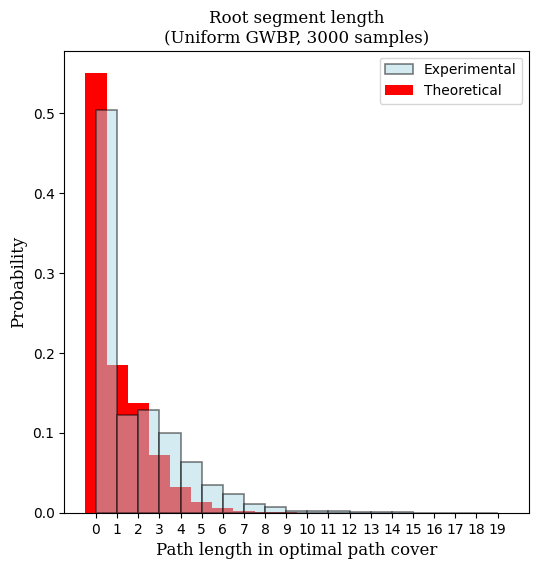

In [32]:
generate_histogram(rsls_unif, func=lambda k: compute_L_unif(k), bins=np.arange(0,20,1),
                   title=f"Root segment length\n(Uniform GWBP, {num_samples} samples)")

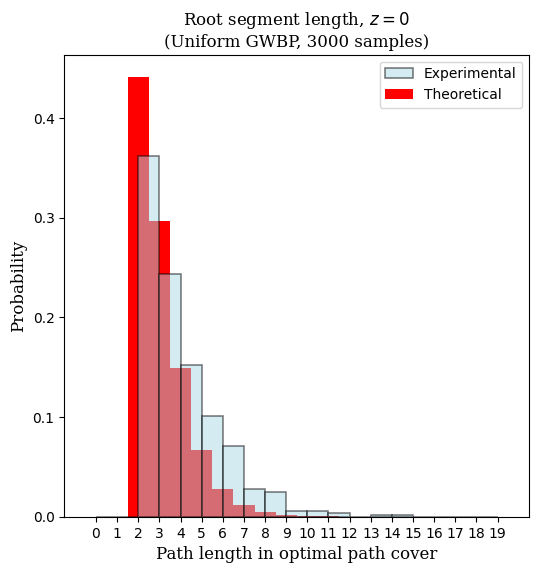

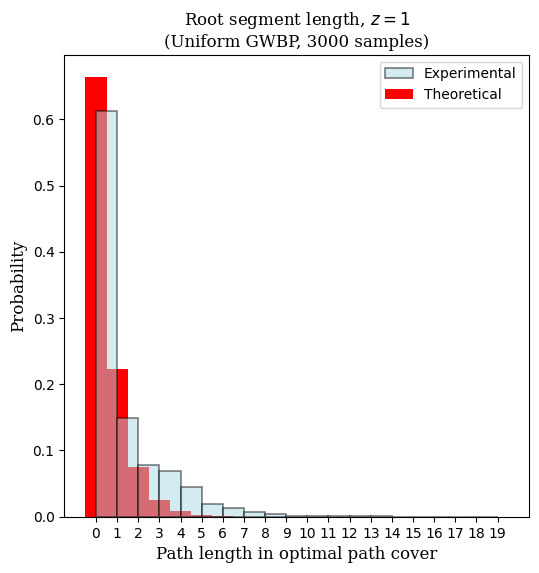

In [33]:
generate_histogram(rsl_z0_unif, func=lambda k: compute_L_zero_unif(k), bins=np.arange(0,20,1),
                   title=f"Root segment length, $z=0$\n(Uniform GWBP, {num_samples} samples)")
generate_histogram(rsl_z1_unif, func=lambda k: compute_L_one_unif(k), bins=np.arange(0,20,1),
                   title=f"Root segment length, $z=1$\n(Uniform GWBP, {num_samples} samples)")

# Galton-Watson Branching Process - $\mathcal{U}(0,1,2,3)$ (supercritical)

In [1]:
LAM = 1.5

In [20]:
def supcrit_X_unif(lam, my_max):
    finite_vals = []
    infinite_vals = []
    for _ in range(num_samples):
        unif_dist = lambda: np.random.choice([0,1,2,3]) # xi = U{0,1,2,3}
        sample_tree, is_finite = GWBP_finite_flag(lam, MAXLEVEL=my_max, dist=unif_dist)
        sample_tree = nx.Graph(sample_tree)
        for u,v in sample_tree.edges():
            sample_tree[u][v]['weight'] = 1
    
        _,_,X,_ = util.path_cover(sample_tree, root=0)
        val = X
        if is_finite:
            finite_vals.append(val)
        else:
            infinite_vals.append(val)
    return finite_vals, infinite_vals

In [21]:
fin_vals, inf_vals = supcrit_X_unif(LAM, 10)

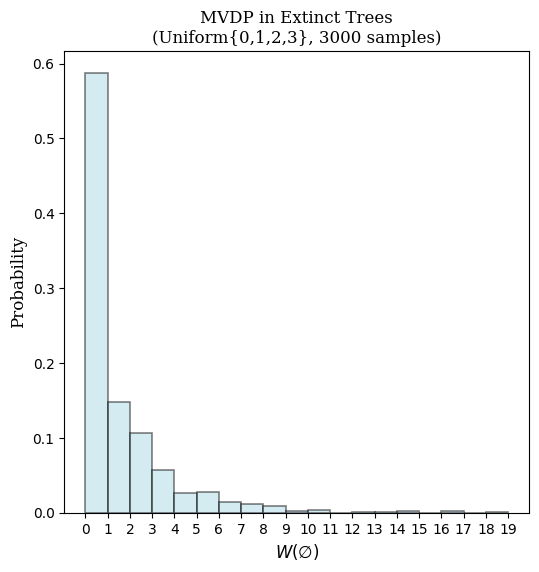

In [42]:
bins = np.arange(0,20,1)
plt.figure(figsize=(6,6))
plt.hist(fin_vals, bins=bins, density=True,
         edgecolor = 'black', linewidth=1.2, color = 'lightblue', alpha=0.5, label='Experimental')
plt.xticks(bins)
plt.title('MVDP in Extinct Trees\n(Uniform{0,1,2,3}, '+f"{num_samples} samples)", fontfamily=['Serif'], fontsize=12)
plt.xlabel("$W(\emptyset)$", fontfamily=['Serif'], fontsize=12)
plt.ylabel("Probability", fontfamily=['Serif'], fontsize=12)
plt.show()